# Дипломный проект: "Анализ результатов внедрения программы лояльности"

## Материалы:

**Ссылка на дашборд:** 
https://public.tableau.com/app/profile/karin.vink/viz/Final_project_16721149442770/Dashboard1?publish=yes

**Ссылка на презентацию:** https://cloud.mail.ru/public/oPgC/oQA5eq8mc

### Описание проекта

**Заказчик:** менеджер проекта, отвечающий за программу лояльности

**Входные данные:** датасет содержит данные о покупках в магазине строительных материалов «Строили, строили и наконец построили» за период декабря 2016 - февраль 2017гг.

**Цель исследования:**  оценить результаты внедрения и понять насколько сработала программа лояльности (проверить, повышаются ли основные показатели у клиентов, использующих программу) для дальнейшего принятия менеджером решения об её использовании.


###  Загрузка данных и подготовка к исследованию

Импортируем необходимые библиотеки:

In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotly import graph_objects as go #для построения круговой диаграммы
import scipy.stats as stats # для проверки стат. гипотез

In [100]:
data = pd.read_csv('retail_dataset.csv')

**Информация о датасете data:**

* purchaseId — id чека;
* item_ID — id товара;
* purchasedate — дата покупки;
* Quantity — количество товара;
* CustomerID — id покупателя;
* ShopID — id магазина;
* loyalty_program — участвует ли покупатель в программе лояльности


In [101]:
data.head()

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


**Проверим корректность наименований колонок в датасете data и выполним переименования:**

In [102]:
data = data.rename(columns={'purchaseid':'purchase_ID', 'purchasedate':'purchase_date','Quantity':'quantity', 'CustomerID':'customer_ID', 'ShopID':'shop_ID'})

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchase_ID      105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   quantity         105335 non-null  int64  
 3   purchase_date    105335 non-null  object 
 4   customer_ID      69125 non-null   float64
 5   shop_ID          105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


In [104]:
df = pd.read_csv('product_codes.csv')

**Информация о датасете df:**

* productID — id товара;
* price_per_one — стоимость одной единицы товара;

In [105]:
df.head(3)

,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75


**Проверим корректность наименований колонок в датасете df и выполним переименования:**

In [106]:
df = df.rename(columns={'productID':'item_ID'}) 

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   item_ID        9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


**Исследуем пропущенные значения:**

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   item_ID        9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


In [109]:
data.isna().sum()

purchase_ID            0
item_ID                0
quantity               0
purchase_date          0
customer_ID        36210
shop_ID                0
loyalty_program        0
dtype: int64

Посмотрим долю пропусков в % от всех данных в столбце customer_ID:

In [110]:
propusk = round(data.isna().mean()*100,1)
propusk

purchase_ID         0.0
item_ID             0.0
quantity            0.0
purchase_date       0.0
customer_ID        34.4
shop_ID             0.0
loyalty_program     0.0
dtype: float64

Т.к. пропуски в столбце customer_ID занимают значительную долю (34,4%) то их удаление негативно полвияет на точность результатов исследования, поэтому в данном случае обработаем пропуски заменив их на нулевые значения.

In [111]:
data['customer_ID'] = data['customer_ID'].fillna(value=0)
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchase_ID      105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   quantity         105335 non-null  int64  
 3   purchase_date    105335 non-null  object 
 4   customer_ID      105335 non-null  float64
 5   shop_ID          105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


Также вызывает вопрос случаи, когда в поле 'quantity' значение = 0, т.е. в данном чеке кол-во данного товара = 0. Тогда почему этот товар присутсвует в чеке? 

In [112]:
len(data[data['quantity']==0])

33055

Проверим, есть ли отрицательные значения в поле 'quantity':

In [113]:
len(data[data['quantity'] < 0])

2118

In [114]:
vozvrat = [data[data['quantity'] < 0]]
vozvrat

[       purchase_ID item_ID  quantity        purchase_date  customer_ID  \
 64         C539944   22776        -2  2016-12-23 11:38:00      20239.0   
 109        C542910   20726        -2  2017-02-01 15:38:00      23190.0   
 112        C542426   22418       -25  2017-01-28 09:32:00      19825.0   
 253        C539726   22791       -11  2016-12-21 14:24:00      22686.0   
 344        C544034   21878        -2  2017-02-15 11:28:00      20380.0   
 ...            ...     ...       ...                  ...          ...   
 105160     C541650       M        -2  2017-01-20 11:44:00          0.0   
 105172     C540246   79320        -2  2017-01-05 15:43:00      18760.0   
 105211     C539467   22801        -2  2016-12-19 12:46:00      20723.0   
 105250     C540847   22197        -3  2017-01-11 17:35:00      19137.0   
 105300     C540164   21144       -13  2017-01-05 12:02:00      20590.0   
 
        shop_ID  loyalty_program  
 64      Shop 0              0.0  
 109     Shop 0             

In [115]:
#chek_vozvrat = [data[data['purchase_ID'] == 'C540246']]
#chek_vozvrat

**Отрицательные значения в поле 'quantity' могут быть связаны с возвратами товаров. Посмотрим, какое количество возвратов в процентном отношении было сделано клиентами программы лояльности, а какое обычными клиентами:**

In [116]:
return_item = (data[data['quantity'] < 0]).groupby(['loyalty_program']).agg({'loyalty_program':'count'}).rename(columns={'loyalty_program':'amount_return_item'})
return_item = return_item.reset_index()
return_item['%'] = round(return_item['amount_return_item']/len(data[data['quantity'] < 0])*100,1)
return_item

,loyalty_program,amount_return_item,%
0,0.0,1673,79.0
1,1.0,445,21.0


**Промежуточные выводы:** по сделанным расчётам видим, что из 2118 наименований товаров, которые были возвращены 21% приходится на покупки по программе лояльности, остальные 79% на остальных покупателей.

Посмотрим, какой процент от всех записей занимают отрицательные значения:

In [117]:
print('% возвратов от всех записей в таблице:', round(len(data[data['quantity'] < 0])/len(data)*100,2))

% возвратов от всех записей в таблице: 2.01


**Для дальнейшего анализа результатов программы исключим данные по возвратам:**

In [118]:
data = data[data['quantity'] >= 0]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103217 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchase_ID      103217 non-null  object 
 1   item_ID          103217 non-null  object 
 2   quantity         103217 non-null  int64  
 3   purchase_date    103217 non-null  object 
 4   customer_ID      103217 non-null  float64
 5   shop_ID          103217 non-null  object 
 6   loyalty_program  103217 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.3+ MB


Посмотрим количество записей может быть по одному и тому же чеку и в результате видим, что идентификатор чека может повторяться в зависимости от того, сколько товаров в нём было, а значит ситуация с тем, что какой-то товар был обозначен в чеке как 0 (например, добавили в чек, а потом отменили) технически допустима.

In [119]:
data['purchase_ID'].value_counts()

537434    675
538071    652
538349    620
537638    601
537237    597
         ... 
541513      1
542783      1
543675      1
543988      1
544612      1
Name: purchase_ID, Length: 3875, dtype: int64

Проверим наличие пропусков в таблице df:

In [120]:
df.isna().sum()

item_ID          0
price_per_one    0
dtype: int64

**Исследуем соответствие типов:**

* purchasedate - необходимо изменить на тип datetime
* CustomerID - необходимо изменить на тип object
* loyalty_program  - необходимо изменить на тип int 

**Выполним изменение типов:**

In [121]:
data['purchase_date']= pd.to_datetime(data['purchase_date'], format ='%Y-%m-%dT%H:%M:%S')

In [122]:
data['customer_ID'] = data['customer_ID'].astype('object')
data['loyalty_program'] = data['loyalty_program'].astype('bool')

In [123]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103217 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_ID      103217 non-null  object        
 1   item_ID          103217 non-null  object        
 2   quantity         103217 non-null  int64         
 3   purchase_date    103217 non-null  datetime64[ns]
 4   customer_ID      103217 non-null  object        
 5   shop_ID          103217 non-null  object        
 6   loyalty_program  103217 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(1), object(4)
memory usage: 5.6+ MB


In [124]:
data.head()

,purchase_ID,item_ID,quantity,purchase_date,customer_ID,shop_ID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,False
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,True
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,True
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,True
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,True


В таблице df с типами всё в порядке, замены не требуется.

**Исследуем наличие дубликатов:**

Сначала посчитаем количество явных строк-дубликатов в таблице:

In [125]:
'Дубликатов в таблице:', data.duplicated().sum() 

('Дубликатов в таблице:', 991)

Удалим строки-дубликаты и заменим индексацию на новую:

In [126]:
data = data.drop_duplicates().reset_index(drop=True) 
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102226 entries, 0 to 102225
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_ID      102226 non-null  object        
 1   item_ID          102226 non-null  object        
 2   quantity         102226 non-null  int64         
 3   purchase_date    102226 non-null  datetime64[ns]
 4   customer_ID      102226 non-null  object        
 5   shop_ID          102226 non-null  object        
 6   loyalty_program  102226 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(1), object(4)
memory usage: 4.8+ MB


Теперь проверим на наличие не явных строк-дубликатов:

дубликаты появляются в сочетании столбцов data[['purchaseid','item_ID','purchasedate', 'CustomerID']], но если мы добавляем к ним столбец Quantity, то дубликатов нет. Как мы выяснили выше, ситуация с разным количеством товаров является нормальной, проблемы в данных с неявными дубликатами нет.

Проверим наличие дубликатов в таблице df:

In [127]:
'Дубликатов в таблице df:', df.duplicated().sum() 

('Дубликатов в таблице df:', 0)

Проверим на неявные дубликаты:

In [128]:
povtor_1 = df.pivot_table(index=['item_ID'], values='price_per_one', aggfunc='count').reset_index()
povtor_1.sort_values(by='price_per_one', ascending = False)

,item_ID,price_per_one
3150,DOT,174
3151,M,59
3153,S,29
3152,POST,15
3139,D,13
...,...,...
2593,85018C,1
2594,85018D,1
2596,85019B,1
2006,47420,1


Видим, что в таблице со стоимостью товаров ряд товаров содержит несколько различных цен. Посмотрим, на двух продуктах, какие это значения, насколько в рамках одного товара они отличаются друг от друга:

In [129]:
df[df['item_ID']=='DOT'].sort_values(by ='price_per_one', ascending= False )

,item_ID,price_per_one
3773,DOT,950.99
3541,DOT,940.87
4733,DOT,907.47
2655,DOT,887.52
4485,DOT,885.94
...,...,...
5724,DOT,50.64
5723,DOT,50.60
5726,DOT,29.53
8778,DOT,3.29


In [130]:
df[df['item_ID']=='M'].sort_values(by ='price_per_one', ascending= False )

,item_ID,price_per_one
8729,M,1715.85
9476,M,1435.79
5777,M,1298.40
8167,M,1283.80
5043,M,1130.90
6243,M,1126.00
3882,M,924.59
9478,M,869.55
9378,M,856.48
9899,M,764.12


Видим, что разброс цен в рамках одного товара может быть очень значительный. Чтобы исключить ситуацию, когда по одному товару в таблице df имеем несколько цен, посчитаем для каждого товара медианное значение цены. 

In [131]:
df = df.pivot_table(index=['item_ID'], values='price_per_one', aggfunc='median').reset_index()
df.sort_values(by='price_per_one', ascending = False).head()

,item_ID,price_per_one
3136,AMAZONFEE,6706.71
1507,22655,265.50
3150,DOT,198.19
1671,22826,175.00
1672,22827,155.00


Посчитаем количество товаров, которые имеют нулевую стоимость: 

In [132]:
len(df[df['price_per_one']==0])

57

In [133]:
df = df.sort_values(by='price_per_one', ascending=False)
df.head()

,item_ID,price_per_one
3136,AMAZONFEE,6706.71
1507,22655,265.50
3150,DOT,198.19
1671,22826,175.00
1672,22827,155.00


In [134]:
data[data['item_ID']=='AMAZONFEE'] 

,purchase_ID,item_ID,quantity,purchase_date,customer_ID,shop_ID,loyalty_program
12285,537632,AMAZONFEE,0,2016-12-07 15:08:00,0.0,Shop 0,False


In [135]:
print('Количество товаров с нулевой стоимостью в таблице df:',len(df[df['price_per_one']==0]))

Количество товаров с нулевой стоимостью в таблице df: 57


Посмотрим на гистограмме, как распределены цены:

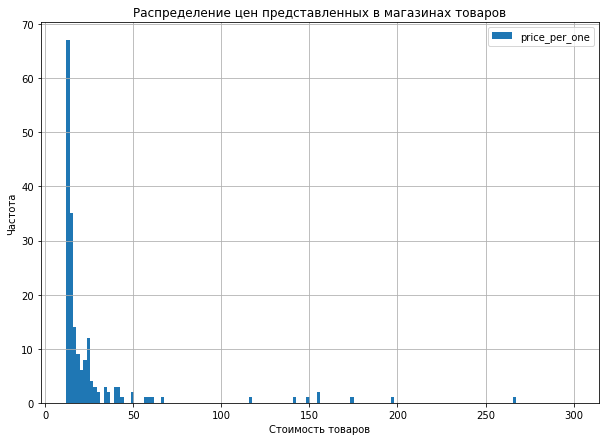

In [136]:
df.plot(kind ='hist', y='price_per_one', bins=150, range=(12,300), grid=True, figsize=(10,7))
plt.xlabel("Стоимость товаров")
plt.ylabel("Частота")
plt.title('Распределение цен представленных в магазинах товаров')

plt.show()

**Промежуточные выводы:** на гистограмме видим и отсортированным данным видим, что в магазинах сети продаются товары в ценовом диапазоне 15 - 45 у.ед., товары по более высокой стоимости встречаются крайне редко.
    
* Есть товар item_ID=='AMAZONFEE', с крайне выходящей за пределы нормальной стомостью (6706.71). Т.к. такой товар был куплен единожды, можем предположить, что такой товар был куплен под заказ и исплючить этот выброс из дальнейших рассчётов, чтобы не искажать показатель среднего чека.

* Также уберем из расчётов товары и покупки с нулевой стоимостью.

In [137]:
df = ( df[
          (df['item_ID']!='AMAZONFEE')
          &(df['price_per_one']!=0)
         ]
     )

Добавим к таблице data данные из таблицы df:

In [138]:
data = data.merge(df, on=['item_ID'], how = 'inner')
data

,purchase_ID,item_ID,quantity,purchase_date,customer_ID,shop_ID,loyalty_program,price_per_one
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,False,1.63
1,541104,21873,0,2017-01-13 14:29:00,0.0,Shop 0,False,1.63
2,540418,21873,1,2017-01-07 11:04:00,0.0,Shop 0,False,1.63
3,541516,21873,2,2017-01-18 17:34:00,0.0,Shop 0,False,1.63
4,541566,21873,35,2017-01-19 11:50:00,23401.0,Shop 0,True,1.63
...,...,...,...,...,...,...,...,...
102201,538200,15058A,0,2016-12-10 11:11:00,23591.0,Shop 0,True,7.95
102202,538852,90058B,35,2016-12-14 13:33:00,23051.0,Shop 0,True,0.38
102203,539988,46138B,1,2016-12-23 16:06:00,23795.0,Shop 0,True,1.95
102204,537025,90053,0,2016-12-03 16:21:00,0.0,Shop 0,False,2.55


In [139]:
print('Покупок с нулевой стоимостью в таблице data:',(len(data[data['price_per_one']==0])))

Покупок с нулевой стоимостью в таблице data: 0


Проверим, что после обогащения данных, количество строк в исходной таблице не изменилось:

In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102206 entries, 0 to 102205
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_ID      102206 non-null  object        
 1   item_ID          102206 non-null  object        
 2   quantity         102206 non-null  int64         
 3   purchase_date    102206 non-null  datetime64[ns]
 4   customer_ID      102206 non-null  object        
 5   shop_ID          102206 non-null  object        
 6   loyalty_program  102206 non-null  bool          
 7   price_per_one    102206 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 6.3+ MB


## Исследовательский анализ данных

**Посмотрим, за какой период получены данные:**

In [141]:
print('Минимальная дата записи:', data['purchase_date'].min())
print('Максимальная дата записи:', data['purchase_date'].max())

Минимальная дата записи: 2016-12-01 08:26:00
Максимальная дата записи: 2017-02-28 17:01:00


Т.е. имеем данные за три месяца: декабрь 2016г, январь и февраль 2017г.

**Добавим в объединенную таблицу столбец с днем недели, месяцем и годом покупки** 

In [142]:
data['day_of_week_sale']=data['purchase_date'].dt.weekday

Выделим из столбца 'purchase_date' дату покупки:

In [143]:
data['day_of_sale']=data['purchase_date'].astype('datetime64[D]')
data['day_of_sale'] = pd.to_datetime(data['day_of_sale'], format = '%Y-%m-%d')

А также выделим месяц и год покупки, для этого приведём столбец 'purchase_date' к формату первое число - месяц – год используем метод astype('datetime64[M]') и результат добавим в новый столбец 'month_year_sale':

In [144]:
data['month_year_sale']=data['purchase_date'].astype('datetime64[M]')

In [145]:
data.head(3)

,purchase_ID,item_ID,quantity,purchase_date,customer_ID,shop_ID,loyalty_program,price_per_one,day_of_week_sale,day_of_sale,month_year_sale
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,False,1.63,5,2016-12-10,2016-12-01
1,541104,21873,0,2017-01-13 14:29:00,0.0,Shop 0,False,1.63,4,2017-01-13,2017-01-01
2,540418,21873,1,2017-01-07 11:04:00,0.0,Shop 0,False,1.63,5,2017-01-07,2017-01-01


Для дальнейших расчётов собёрем из таблицы data данные по каждому чеку:

In [146]:
cheki = data.pivot_table(index=['purchase_ID', 'customer_ID', 'shop_ID','loyalty_program','purchase_date','day_of_sale','day_of_week_sale','month_year_sale'], values='price_per_one', aggfunc='sum').reset_index()
cheki.sort_values(by='price_per_one', ascending = False)
cheki=cheki.rename(columns={'price_per_one':'purchase_price'})
cheki.head()

,purchase_ID,customer_ID,shop_ID,loyalty_program,purchase_date,day_of_sale,day_of_week_sale,month_year_sale,purchase_price
0,536365,23529.0,Shop 0,True,2016-12-01 08:26:00,2016-12-01,3,2016-12-01,45.905
1,536366,23529.0,Shop 0,True,2016-12-01 08:28:00,2016-12-01,3,2016-12-01,3.950
2,536367,18726.0,Shop 0,False,2016-12-01 08:34:00,2016-12-01,3,2016-12-01,69.455
3,536368,18726.0,Shop 0,False,2016-12-01 08:34:00,2016-12-01,3,2016-12-01,38.640
4,536369,18726.0,Shop 0,False,2016-12-01 08:35:00,2016-12-01,3,2016-12-01,6.600


Рассчитаем количество покупок за каждый день и построим соответсующий график:

In [147]:
day_of_sale = cheki.pivot_table(index=['day_of_sale'], values='purchase_price', aggfunc='count').reset_index()
day_of_sale=day_of_sale.rename(columns={'purchase_price':'cnt_sale'})
day_of_sale.head()

,day_of_sale,cnt_sale
0,2016-12-01,132
1,2016-12-02,143
2,2016-12-03,72
3,2016-12-05,88
4,2016-12-06,108


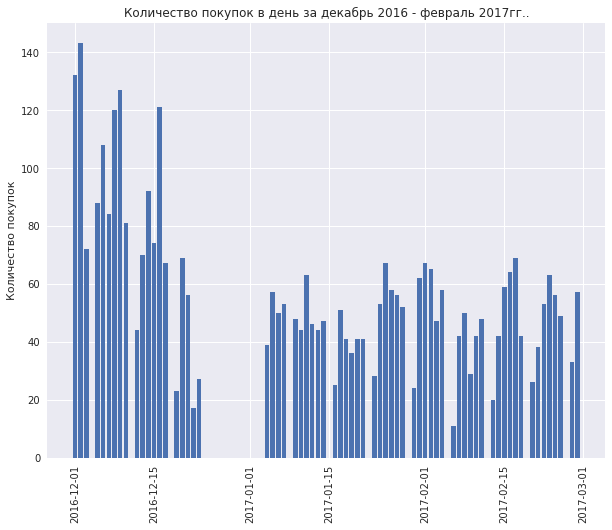

In [148]:
plt.figure(figsize=(10,8))
with plt.style.context('seaborn'):
    plt.bar(day_of_sale['day_of_sale'], day_of_sale['cnt_sale'])
    plt.title('Количество покупок в день за декабрь 2016 - февраль 2017гг..')
    plt.ylabel('Количество покупок')
    plt.xticks(rotation=90)
plt.show()

**Промежуточные выводы:** на графике видим, что количество покупок в день в декабрь 2016 до середины месяца было выше, чем январе и феврале 2017г., что могло быть связано со стремлением людей завершить ремонтные и строительные работы в предверии праздников. В конце декабря и начале января видим пробел в продажах. Он может быть связан как с техническими проблемами в записи данных, так и с графиком работы магазинов. 
В первом случае - необходимо обратить на причины технических проблем для их избежания в дальнейшем. Во втором случае - обратить внимание на график работы в конце и начале года в праздничные дни, т.к. для сети магазинов это может ежегодно быть причиной недополучения значительной прибыли.

### Средний чек

Посчитаем средний чек по всем данным за имеющийся период для покупателей, учавствующих и НЕ учавствующих в программе лояльности:

In [149]:
mean_chek = cheki.pivot_table(index=['loyalty_program'], values = 'purchase_price', aggfunc ='mean').reset_index()
mean_chek.rename(columns={'purchase_price':'mean_chek'})

,loyalty_program,mean_chek
0,False,133.491759
1,True,87.190739


**Теперь расчитаем показатель среднего чека по каждому месяцу, с разделением на учавствующих и нет в программе лояльности:**

**(без учёта стоимости покупки карты для участия в программе лояльности)**

Выделим из таблицы cheki, чеки покупателей учавствующих в программе лояльности и не учавствующих:

In [150]:
prog_da = cheki[cheki['loyalty_program']==1]

In [151]:
prog_net = cheki[cheki['loyalty_program']==0]

Расчитаем средние чеки по месяцам для обоих категорий клиентов:

In [152]:
mean_month_chek_da = prog_da.pivot_table(index=['month_year_sale', 'loyalty_program'], values='purchase_price', aggfunc='mean').reset_index()
mean_month_chek_da = mean_month_chek_da.rename(columns={'purchase_price':'mean_chek_prog_da'})
mean_month_chek_da

,month_year_sale,loyalty_program,mean_chek_prog_da
0,2016-12-01,True,82.398444
1,2017-01-01,True,98.819741
2,2017-02-01,True,84.433881


In [153]:
mean_month_chek_net = prog_net.pivot_table(index=['month_year_sale', 'loyalty_program'], values='purchase_price', aggfunc='mean').reset_index()
mean_month_chek_net = mean_month_chek_net.rename(columns={'purchase_price':'mean_chek_prog_net', })
mean_month_chek_net

,month_year_sale,loyalty_program,mean_chek_prog_net
0,2016-12-01,False,130.553687
1,2017-01-01,False,146.122799
2,2017-02-01,False,124.289346


Объединим полученные таблицы в одну для построения графика:

In [154]:
tab = mean_month_chek_da.merge(mean_month_chek_net, on = 'month_year_sale', how = 'left')

# сделаем замену значений в столбце 'month_year_sale', чтобы на графике период отображался в более удобном виде:
#tab['month_year_sale']= tab['month_year_sale'].replace(['2016-12-01','2017-01-01','2017-02-01'],['Декабрь 2016','Январь 2017','Февраль 2017'])
tab['month_year_sale'] = tab['month_year_sale'].dt.strftime('%B,%Y')
tab

,month_year_sale,loyalty_program_x,mean_chek_prog_da,loyalty_program_y,mean_chek_prog_net
0,"December,2016",True,82.398444,False,130.553687
1,"January,2017",True,98.819741,False,146.122799
2,"February,2017",True,84.433881,False,124.289346


Отобразим полученные расчётные значения на графике:

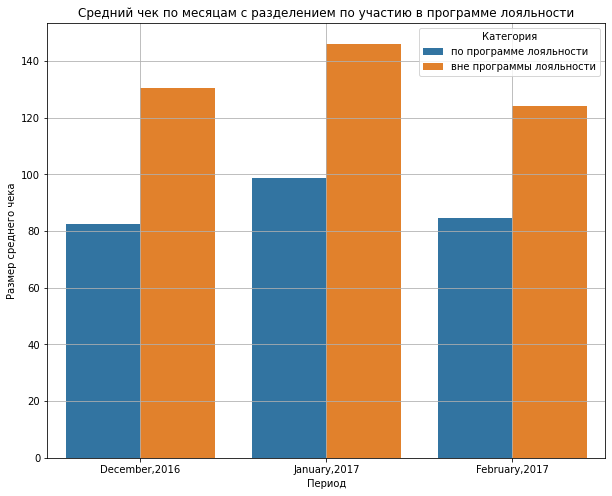

In [155]:
month = tab['month_year_sale']

# добавляем на график данные по месяцам о размере среднего чека клиентов, учавствующих 'в программе'
da = tab[['month_year_sale','mean_chek_prog_da']].rename(columns={'mean_chek_prog_da':'mean_chek'})
da['Категория'] = 'по программе лояльности'

# добавляем на график данные по месяцам о размере среднего чека клиентов, 'вне программы'
net = tab[['month_year_sale','mean_chek_prog_net']].rename(columns={'mean_chek_prog_net':'mean_chek'})
net['Категория'] = 'вне программы лояльности'



plt.figure(figsize=(10,8))

concat=pd.concat([da,net])
sns.barplot(x='month_year_sale', y='mean_chek', hue='Категория', data=concat)

plt.grid()
plt.title('Средний чек по месяцам с разделением по участию в программе лояльности')
plt.xlabel('Период')
plt.ylabel('Размер среднего чека')
plt.xticks #(rotation=90)
plt.show()

**Промежуточные выводы:** по сделанным расчетам и графику видим, что средний чек покупок, сделанных по программе лояльности за все месяца исследуемого периода существенно меньше, чем средний чек покупок вне программы лояльности.

#### Дополнительно посмотрим, как выглядит распределение размеров чеков по при использовании программы лояльности и без неё:

Построим диаграмму размаха ("Ящик с усами") по размерам чеков с использованием программы и без неё:

(0.0, 500.0)

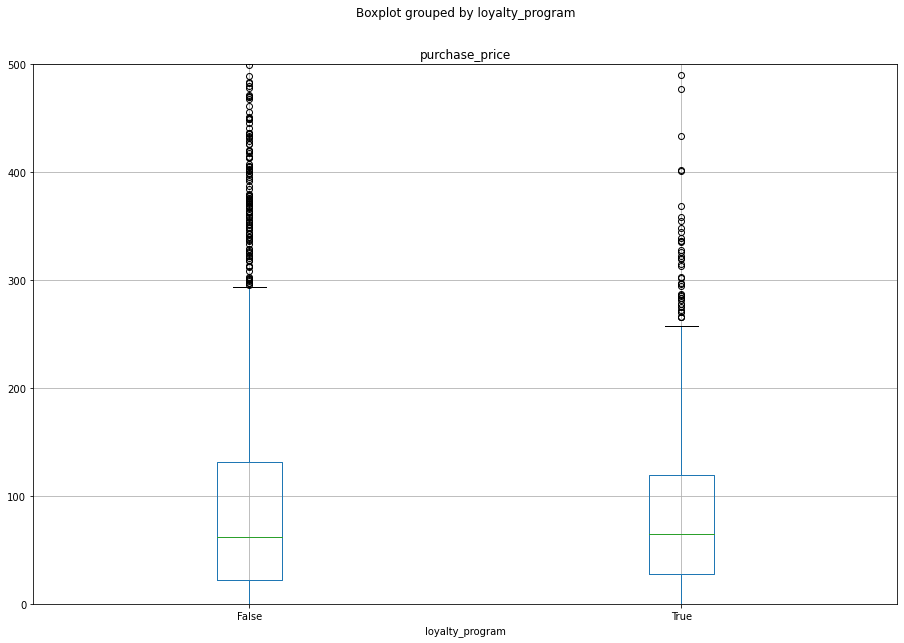

In [156]:
cheki.boxplot(column='purchase_price', by='loyalty_program', figsize=(15,10))

plt.ylim([0, 500])

По диаграмме размаха ("Ящик с усами") видим, что нормальным распределением значений размера чеков для каждой категории (0 и 1) являются следующие значения:
* 0- покупки без участия в программе: стоимостью до 250 руб.
* 1- покупки с участием в программе:  стоимостью до 240 руб.  

Значения, расположенные после, являются выбросами.

### Среднее количество покупок

**Сначала определим соотношение покупок по количеству, сделанных по программе лояльности и вне её:**

Рассчитаем и посмотрим на графике, количество и долю покупок сделанных по программе лояльности и вне её:

In [157]:
cheki.head(5)

,purchase_ID,customer_ID,shop_ID,loyalty_program,purchase_date,day_of_sale,day_of_week_sale,month_year_sale,purchase_price
0,536365,23529.0,Shop 0,True,2016-12-01 08:26:00,2016-12-01,3,2016-12-01,45.905
1,536366,23529.0,Shop 0,True,2016-12-01 08:28:00,2016-12-01,3,2016-12-01,3.950
2,536367,18726.0,Shop 0,False,2016-12-01 08:34:00,2016-12-01,3,2016-12-01,69.455
3,536368,18726.0,Shop 0,False,2016-12-01 08:34:00,2016-12-01,3,2016-12-01,38.640
4,536369,18726.0,Shop 0,False,2016-12-01 08:35:00,2016-12-01,3,2016-12-01,6.600


In [158]:
status_prog_chek_net = len(cheki[cheki['loyalty_program']==False])
print('Количество покупок вне программы лояльности:', status_prog_chek_net) 

Количество покупок вне программы лояльности: 2735


In [159]:
status_prog_chek_da = len(cheki[cheki['loyalty_program']==True])
print('Количество покупок по программе лояльности:',status_prog_chek_da)

Количество покупок по программе лояльности: 1136


In [160]:
name_rest = ['Кол-во покупок по программе', 'Кол-во покупок вне программы']
values = [status_prog_chek_da, status_prog_chek_net]

fig = go.Figure(data=[go.Pie(labels=name_rest, values=values)])
fig.show() 

<div class="alert alert-danger">
    
**Комментарий ревьюера**

**#ошибка**

Для построения графика используй данные из таблицы. Вводить числа вручную - плохой стиль (хардкод). При любом изменении в данных (в предобработке, например) тебе придется менять все руками
</div>

**Промежуточные вывыоды.** На графике видим:
* что 70,8%  покупок за исследуемый период сделаны вне программы лояльности,
* 29,2% покупок сделано по программе лояльности.

**Посчитаем количество покупок по месяцам:**

In [161]:
cnt_month_chek_da = prog_da.pivot_table(index=['month_year_sale', 'loyalty_program'], values='purchase_price', aggfunc='count').reset_index()
cnt_month_chek_da = cnt_month_chek_da.rename(columns={'purchase_price':'number_chek_prog_da'})
cnt_month_chek_da

,month_year_sale,loyalty_program,number_chek_prog_da
0,2016-12-01,True,511
1,2017-01-01,True,290
2,2017-02-01,True,335


In [162]:
cnt_month_chek_net = prog_net.pivot_table(index=['month_year_sale', 'loyalty_program'], values='purchase_price', aggfunc='count').reset_index()
cnt_month_chek_net= cnt_month_chek_net.rename(columns={'purchase_price':'number_chek_prog_net'})
cnt_month_chek_net

,month_year_sale,loyalty_program,number_chek_prog_net
0,2016-12-01,False,1104
1,2017-01-01,False,836
2,2017-02-01,False,795


Объединим полученные таблицы в одну для построения графика:

In [163]:
union_tab = cnt_month_chek_da.merge(cnt_month_chek_net, on = 'month_year_sale', how = 'left')
# сделаем замену значений в столбце 'month_year_sale', чтобы на графике период отображался в более удобном виде:
#union_tab ['month_year_sale']= union_tab ['month_year_sale'].replace(['2016-12-01','2017-01-01','2017-02-01'],['Декабрь 2016','Январь 2017','Февраль 2017'])
union_tab['month_year_sale'] = union_tab['month_year_sale'].dt.strftime('%B,%Y')

In [164]:
union_tab

,month_year_sale,loyalty_program_x,number_chek_prog_da,loyalty_program_y,number_chek_prog_net
0,"December,2016",True,511,False,1104
1,"January,2017",True,290,False,836
2,"February,2017",True,335,False,795


Отобразим полученные расчётные значения на графике:

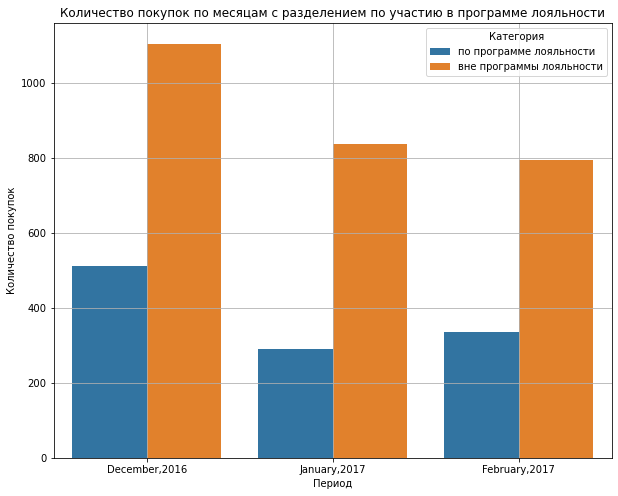

In [165]:
month = union_tab['month_year_sale']

# добавляем на график данные по месяцам о размере среднего чека клиентов, учавствующих 'в программе'
da = union_tab[['month_year_sale','number_chek_prog_da']].rename(columns={'number_chek_prog_da':'number_chek'})
da['Категория'] = 'по программе лояльности'

# добавляем на график данные по месяцам о размере среднего чека клиентов, 'вне программы'
net = union_tab[['month_year_sale','number_chek_prog_net']].rename(columns={'number_chek_prog_net':'number_chek'})
net['Категория'] = 'вне программы лояльности'



plt.figure(figsize=(10,8))

concat=pd.concat([da,net])
sns.barplot(x='month_year_sale', y='number_chek', hue='Категория', data=concat)

plt.grid()
plt.title('Количество покупок по месяцам с разделением по участию в программе лояльности')
plt.xlabel('Период')
plt.ylabel('Количество покупок')
plt.xticks #(rotation=90)
plt.show()

**Промежуточные выводы:** на графике видим, что количество покупок по программе лояльности по всем рассматриевым месяцам значительно меньше кол-ва покупок вне программы лояльности.

Теперь рассчитаем среднее количество покупок на одного покупателя по месяцам, также с учётом участия в программе лояльности.

Для расчёта используем таблицу ранее созданную cheki, разделённую на две части - данные о покупка по программе лояльности (таблица prog_da) и вне программы (таблица prog_net).

По программе лояльности посчитаем количество покупок у каждого покупателя в каждом расчётном месяце:

In [166]:
number_sale_da = prog_da.pivot_table(index=['month_year_sale', 'customer_ID'], values='purchase_price', aggfunc='count').reset_index()
number_sale_da = number_sale_da.rename(columns={'purchase_price':'number'})
number_sale_da

,month_year_sale,customer_ID,number
0,2016-12-01,22006.0,1
1,2016-12-01,22032.0,4
2,2016-12-01,22044.0,2
3,2016-12-01,22046.0,1
4,2016-12-01,22064.0,1
...,...,...,...
807,2017-02-01,23909.0,1
808,2017-02-01,23910.0,1
809,2017-02-01,23929.0,1
810,2017-02-01,23936.0,2


Здесь необходимо всмомнить, что в столбце 'customer_ID' у нас есть пропуски, которые мы заменили на нулевые значения. В данном случае их учёт может исказить результаты расчётов среднего количества покупок на одного покупателя, поэтому отфильруем таких "покупателей" на данном шаге: 

In [167]:
number_sale_da = number_sale_da[number_sale_da['customer_ID']!=0]

Теперь посчитаем **среднее количество покупок у покупателей, учавствующих в программе лояльности**: 

In [168]:
mean_number_sale_da = number_sale_da.pivot_table(index=['month_year_sale'], values='number', aggfunc='mean').reset_index()
mean_number_sale_da = mean_number_sale_da.rename(columns={'number':'mean_number_da'})
mean_number_sale_da['mean_number_da']= round(mean_number_sale_da['mean_number_da'],2)
mean_number_sale_da

,month_year_sale,mean_number_da
0,2016-12-01,1.59
1,2017-01-01,1.26
2,2017-02-01,1.29


Аналогично посчитаем количество покупок у каждого покупателя вне программе лояльности в каждом расчётном месяце:

In [169]:
number_sale_net = prog_net.pivot_table(index=['month_year_sale', 'customer_ID'], values='purchase_price', aggfunc='count').reset_index()
number_sale_net = number_sale_net.rename(columns={'purchase_price':'number'})
number_sale_net

,month_year_sale,customer_ID,number
0,2016-12-01,0.0,214
1,2016-12-01,18026.0,1
2,2016-12-01,18027.0,1
3,2016-12-01,18049.0,2
4,2016-12-01,18056.0,1
...,...,...,...
1570,2017-02-01,21934.0,1
1571,2017-02-01,21944.0,2
1572,2017-02-01,21985.0,3
1573,2017-02-01,21996.0,1


Здесь также отфильтруем из расчёта покупателей, у которых не был записан идентификатор:

In [170]:
number_sale_net = number_sale_net[number_sale_net['customer_ID']!=0]

Теперь посчитаем **среднее количество покупок у покупателей, НЕ учавствующих в программе лояльности**:

In [171]:
mean_number_sale_net = number_sale_net.pivot_table(index=['month_year_sale'], values='number', aggfunc='mean').reset_index()
mean_number_sale_net = mean_number_sale_net.rename(columns={'number':'mean_number_net'})
mean_number_sale_net['mean_number_net']= round(mean_number_sale_net['mean_number_net'],2)
mean_number_sale_net

,month_year_sale,mean_number_net
0,2016-12-01,1.58
1,2017-01-01,1.38
2,2017-02-01,1.34


Объединим полученные таблицы в одну для построения графика:

In [172]:
res_tab = mean_number_sale_da.merge(mean_number_sale_net, on = 'month_year_sale', how = 'left')

# сделаем замену значений в столбце 'month_year_sale', чтобы на графике период отображался в более удобном виде:
#res_tab['month_year_sale']= res_tab['month_year_sale'].replace(['2016-12-01','2017-01-01','2017-02-01'],['Декабрь 2016','Январь 2017','Февраль 2017'])
res_tab['month_year_sale'] = res_tab['month_year_sale'].dt.strftime('%B,%Y')
res_tab

,month_year_sale,mean_number_da,mean_number_net
0,"December,2016",1.59,1.58
1,"January,2017",1.26,1.38
2,"February,2017",1.29,1.34


Посмотрим наглядно полученный результат расчетов:

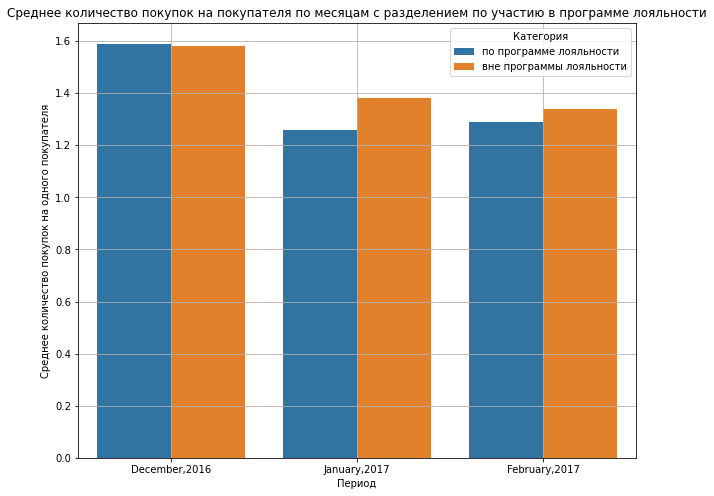

In [173]:
month = res_tab['month_year_sale']

# добавляем на график данные по месяцам о размере среднего чека клиентов, учавствующих 'в программе'
da = res_tab[['month_year_sale','mean_number_da']].rename(columns={'mean_number_da':'number_sale'})
da['Категория'] = 'по программе лояльности'

# добавляем на график данные по месяцам о размере среднего чека клиентов, 'вне программы'
net = res_tab[['month_year_sale','mean_number_net']].rename(columns={'mean_number_net':'number_sale'})
net['Категория'] = 'вне программы лояльности'



plt.figure(figsize=(10,8))

concat=pd.concat([da,net])
sns.barplot(x='month_year_sale', y='number_sale', hue='Категория', data=concat)

plt.grid()
plt.title('Среднее количество покупок на покупателя по месяцам с разделением по участию в программе лояльности')
plt.xlabel('Период')
plt.ylabel('Среднее количество покупок на одного покупателя')
plt.xticks #(rotation=90)
plt.show()

**Промежуточные выводы:** из расчетов и графика видим, что по показателю "Среднее количество покупок на одного покупателя" у покупателей вне программы лояльности этот показатель чуть выше, чем у покупателей учавствующих в программе.

**Сделаем расчёт общей выручки от пользователя**

In [174]:
data.head(3)

,purchase_ID,item_ID,quantity,purchase_date,customer_ID,shop_ID,loyalty_program,price_per_one,day_of_week_sale,day_of_sale,month_year_sale
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,False,1.63,5,2016-12-10,2016-12-01
1,541104,21873,0,2017-01-13 14:29:00,0.0,Shop 0,False,1.63,4,2017-01-13,2017-01-01
2,540418,21873,1,2017-01-07 11:04:00,0.0,Shop 0,False,1.63,5,2017-01-07,2017-01-01


**Составим профили пользователей:**
* ID клиента, 
* ID магазина, 
* участие в программе лояльности, 
* дата и время первой покупки, 
* дата первой покупки, 
* месяц первой покупки 

Предварительно отфильтруем строки, где customer_ID=0

In [175]:
data_cl = data[data['customer_ID']!=0]
data_cl.head(1)

,purchase_ID,item_ID,quantity,purchase_date,customer_ID,shop_ID,loyalty_program,price_per_one,day_of_week_sale,day_of_sale,month_year_sale
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,False,1.63,5,2016-12-10,2016-12-01


Для создания пользовательских профилей напишем функцию `get_profiles()`. В ней сгруппируем значения датафрейма по пользовательскому ID и применим функцию `first()`:

In [176]:
def get_profiles(data_cl):

    # сортируем данные по ID пользователя и дате покупок
    # группируем по ID и находим первые значения purchase_date и shop_ID
    # столбец с датой и временем первой покупки назовём first_sale
    profiles = (
        data_cl.sort_values(by=['customer_ID', 'purchase_date'])
        .groupby('customer_ID')
        .agg({'purchase_date': 'first', 'shop_ID': 'first', 'loyalty_program':'first'})
        .rename(columns={'purchase_date': 'first_sale'})
        .reset_index()  # возвращаем customer_ID из индекса
    )
    
    # добавляем признак участия клиента в программе лояльности
    #profiles['loyalty_program'] = profiles['customer_ID'].isin(data_cl['customer_ID'].unique())

    # определяем дату первой покупки 
    profiles['dt'] = profiles['first_sale'].dt.date
    # и первый день месяца, в который эта покупка произошла
    profiles['month'] = profiles['first_sale'].astype('datetime64[M]')
    profiles['day_of_month'] = profiles['first_sale'].dt.day
    

    return profiles

Вызовем функцию get_profiles(), чтобы составить профили пользователей из датафрейма data_cl:

In [177]:
profiles = get_profiles(data_cl)
profiles.head(3)

,customer_ID,first_sale,shop_ID,loyalty_program,dt,month,day_of_month
0,18025.0,2017-01-18 10:01:00,Shop 0,False,2017-01-18,2017-01-01,18
1,18026.0,2016-12-07 14:57:00,Shop 15,False,2016-12-07,2016-12-01,7
2,18027.0,2016-12-16 19:09:00,Shop 22,False,2016-12-16,2016-12-01,16


Имея готовые профили пользователей, легко узнать количество привлечённых каждым магазином за исследуемый период и результат посмотрим на графике:

In [178]:
shop= profiles.groupby('shop_ID').agg({'customer_ID':'nunique'}).reset_index()

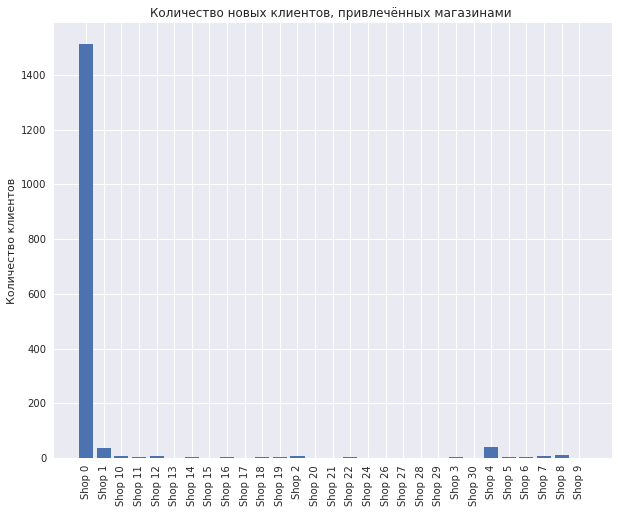

In [179]:
plt.figure(figsize=(10,8))
with plt.style.context('seaborn'):
    plt.bar(shop['shop_ID'], shop['customer_ID'])
    plt.title('Количество новых клиентов, привлечённых магазинами ')
    plt.ylabel('Количество клиентов')
    plt.xticks(rotation=90)
plt.show()

**Промежуточные выводы:** по графику видим, что абсолюным лидером по привлечению клиентов ялвяется магазин с идентификатором  Shop 0. 

А также можем посмотреть динамику привлечения покупателей за исследуемый период:

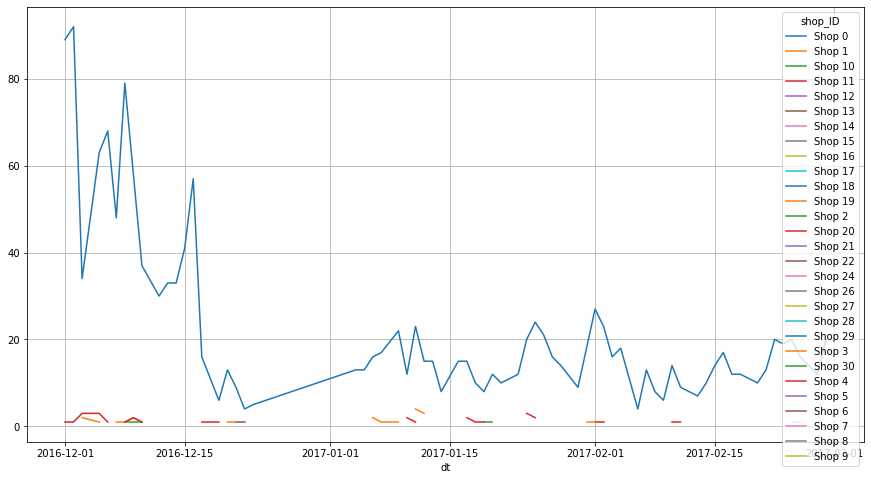

In [180]:
profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns='shop_ID',  # источники переходов
    values='customer_ID',  # ID пользователей
    aggfunc='nunique'  # подсчёт уникальных значений
).plot(figsize=(15, 8), grid=True)

plt.show()

**Промежуточные выводы:** по графику видим, что у магазина с идентификатором Shop 0 на протяжении всего времени отличается регулярностью привлечения новых покупателей. Особенно успешным по параметру привлечения является для магазина первая половина декабря 2016г.

Разделим всех покупателей на три когорты по событию: совершившение первой покупку в декабре 2016, январе 2017 и феврале 2017.
Дополнительный признак: участие в программе лояльности.

При этом участниками когорты будем считать тех клиентов, которые зарегистрировались с 1 по 7 число каждого месяца.

Таким образом каждый из клиентов после регистрации в начале месяца будет иметь период на покупки как минимум 21 день (т.к. в феврале 28 дней).

In [181]:
profiles_gorizont= (profiles[
                             (profiles['day_of_month']>=1)
                            &(profiles['day_of_month']<=7)
                            ]
                   )
profiles_gorizont #.head(3)

,customer_ID,first_sale,shop_ID,loyalty_program,dt,month,day_of_month
1,18026.0,2016-12-07 14:57:00,Shop 15,False,2016-12-07,2016-12-01,7
3,18029.0,2017-02-02 16:01:00,Shop 5,False,2017-02-02,2017-02-01,2
12,18052.0,2017-02-01 13:10:00,Shop 20,False,2017-02-01,2017-02-01,1
18,18074.0,2016-12-03 16:35:00,Shop 12,False,2016-12-03,2016-12-01,3
21,18089.0,2017-02-04 10:38:00,Shop 7,False,2017-02-04,2017-02-01,4
...,...,...,...,...,...,...,...
1669,23905.0,2017-01-06 09:00:00,Shop 0,True,2017-01-06,2017-01-01,6
1670,23908.0,2016-12-01 16:25:00,Shop 0,True,2016-12-01,2016-12-01,1
1674,23918.0,2016-12-02 17:48:00,Shop 0,True,2016-12-02,2016-12-01,2
1676,23929.0,2017-02-02 13:16:00,Shop 0,True,2017-02-02,2017-02-01,2


Подготовим данные о покупках помесячно:

In [182]:
data_cl.head(1)

,purchase_ID,item_ID,quantity,purchase_date,customer_ID,shop_ID,loyalty_program,price_per_one,day_of_week_sale,day_of_sale,month_year_sale
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,False,1.63,5,2016-12-10,2016-12-01


In [183]:
sum_sale = data_cl.pivot_table(index=['customer_ID', 'month_year_sale'], values='price_per_one', aggfunc='sum').reset_index()
sum_sale = sum_sale.rename(columns={'price_per_one':'sum_month_sale'})
sum_sale['sum_month_sale']= round(sum_sale['sum_month_sale'],1)
sum_sale.head()

,customer_ID,month_year_sale,sum_month_sale
0,18025.0,2017-01-01,1.0
1,18026.0,2016-12-01,138.1
2,18026.0,2017-01-01,115.7
3,18027.0,2016-12-01,33.8
4,18027.0,2017-01-01,17.3


Выделим из таблицы sum_sale для каждого пользователя сумму покупок за первый месяц его обслуживания в магазине за исследуемый период: 

In [184]:
sum_sale_first = sum_sale.sort_values(by=['customer_ID', 'month_year_sale']).groupby('customer_ID').agg({'month_year_sale': 'first', 'sum_month_sale': 'first'})
sum_sale_first= sum_sale_first.rename(columns={'sum_month_sale': 'sum_first_month_sale'}).reset_index() 
sum_sale_first.head()

,customer_ID,month_year_sale,sum_first_month_sale
0,18025.0,2017-01-01,1.0
1,18026.0,2016-12-01,138.1
2,18027.0,2016-12-01,33.8
3,18029.0,2017-02-01,48.6
4,18031.0,2017-02-01,93.1


Добавим к таблице profiles_gorizont данные о покупках: 

In [185]:
profiles_gorizont_sale = profiles_gorizont.merge(sum_sale_first, on ='customer_ID', how = 'left')
profiles_gorizont_sale

,customer_ID,first_sale,shop_ID,loyalty_program,dt,month,day_of_month,month_year_sale,sum_first_month_sale
0,18026.0,2016-12-07 14:57:00,Shop 15,False,2016-12-07,2016-12-01,7,2016-12-01,138.1
1,18029.0,2017-02-02 16:01:00,Shop 5,False,2017-02-02,2017-02-01,2,2017-02-01,48.6
2,18052.0,2017-02-01 13:10:00,Shop 20,False,2017-02-01,2017-02-01,1,2017-02-01,57.8
3,18074.0,2016-12-03 16:35:00,Shop 12,False,2016-12-03,2016-12-01,3,2016-12-01,130.3
4,18089.0,2017-02-04 10:38:00,Shop 7,False,2017-02-04,2017-02-01,4,2017-02-01,178.9
...,...,...,...,...,...,...,...,...,...
597,23905.0,2017-01-06 09:00:00,Shop 0,True,2017-01-06,2017-01-01,6,2017-01-01,96.0
598,23908.0,2016-12-01 16:25:00,Shop 0,True,2016-12-01,2016-12-01,1,2016-12-01,103.3
599,23918.0,2016-12-02 17:48:00,Shop 0,True,2016-12-02,2016-12-01,2,2016-12-01,135.5
600,23929.0,2017-02-02 13:16:00,Shop 0,True,2017-02-02,2017-02-01,2,2017-02-01,108.3


Теперь рассчитаем:

* размер когорт (декабрьская, январская и февральская с разделением по признаку участия в программе лояльности)
* сумму покупок, сделанных в каждой кагорте

In [186]:
itog_tab = profiles_gorizont_sale.groupby(['month','loyalty_program']).agg({'customer_ID':'count', 'sum_first_month_sale':'sum' }).reset_index()
itog_tab =itog_tab.rename(columns={'customer_ID':'cohor_size', 'sum_first_month_sale':'sum_cohor_sale'})
itog_tab

,month,loyalty_program,cohor_size,sum_cohor_sale
0,2016-12-01,False,268,42479.0
1,2016-12-01,True,155,22993.3
2,2017-01-01,False,48,6475.9
3,2017-01-01,True,20,2605.4
4,2017-02-01,False,76,7854.0
5,2017-02-01,True,35,3388.5


Учтём тот факт, что для участия в программе лояльности клиентам необходимо оплатить 200 руб/мес:

In [187]:
def alert_program_category(loyalty_program): 
    if loyalty_program == True:
        return 200
    return 0
#print(alert_program_category(True)) #выполним проверку работы функции

Теперь создадим доп. столбец, отражающий стоимость участия в программе и добавим итоговый столбец с суммарной суммой покупок с учётом дохода от продаж карт участия в программе лояльности:

In [188]:
itog_tab['pay_program']=itog_tab['loyalty_program'].apply(alert_program_category)*itog_tab['cohor_size']
itog_tab['total_cohor_sale'] = itog_tab['sum_cohor_sale']+ itog_tab['pay_program']
itog_tab

,month,loyalty_program,cohor_size,sum_cohor_sale,pay_program,total_cohor_sale
0,2016-12-01,False,268,42479.0,0,42479.0
1,2016-12-01,True,155,22993.3,31000,53993.3
2,2017-01-01,False,48,6475.9,0,6475.9
3,2017-01-01,True,20,2605.4,4000,6605.4
4,2017-02-01,False,76,7854.0,0,7854.0
5,2017-02-01,True,35,3388.5,7000,10388.5


Сделаем итоговый расчёт средней выручки от пользователя, начавших обслуживание в магазине с 1 по 7 число каждого месяца включительно у учётом участия в программе лояльности: 

In [189]:
itog_tab['ltv'] = round(itog_tab['total_cohor_sale']/itog_tab['cohor_size'],1) 
itog_tab['month'] = itog_tab['month'].dt.strftime('%B,%Y')
itog_tab

,month,loyalty_program,cohor_size,sum_cohor_sale,pay_program,total_cohor_sale,ltv
0,"December,2016",False,268,42479.0,0,42479.0,158.5
1,"December,2016",True,155,22993.3,31000,53993.3,348.3
2,"January,2017",False,48,6475.9,0,6475.9,134.9
3,"January,2017",True,20,2605.4,4000,6605.4,330.3
4,"February,2017",False,76,7854.0,0,7854.0,103.3
5,"February,2017",True,35,3388.5,7000,10388.5,296.8


Отобразим результаты расчётов на графике:

In [190]:
itog_tab_da = itog_tab[itog_tab['loyalty_program']==True]
itog_tab_net = itog_tab[itog_tab['loyalty_program']==False]

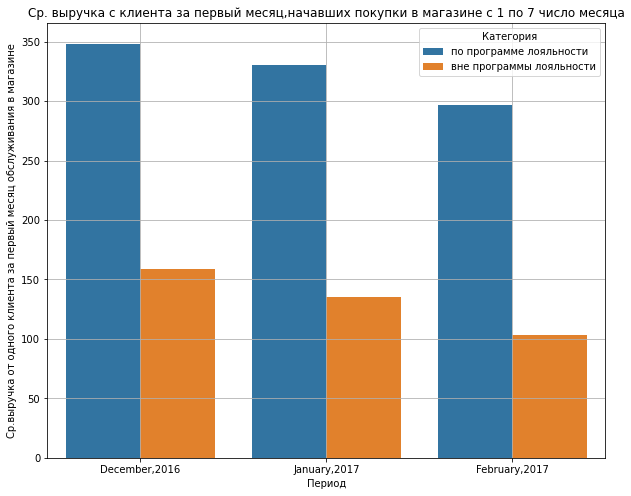

In [191]:
month = itog_tab_da['month']

# добавляем на график данные по месяцам о размере среднего чека клиентов, учавствующих 'в программе'
da = itog_tab_da[['month','ltv']]#.rename(columns={'mean_number_da':'number_sale'})
da['Категория'] = 'по программе лояльности'

# добавляем на график данные по месяцам о размере среднего чека клиентов, 'вне программы'
net = itog_tab_net[['month','ltv']] #.rename(columns={'mean_number_net':'number_sale'})
net['Категория'] = 'вне программы лояльности'



plt.figure(figsize=(10,8))

concat=pd.concat([da,net])
sns.barplot(x='month', y='ltv', hue='Категория', data=concat)

plt.grid()
plt.title('Ср. выручка с клиента за первый месяц,начавших покупки в магазине с 1 по 7 число месяца')
plt.xlabel('Период')
plt.ylabel('Ср.выручка от одного клиента за первый месяц обслуживания в магазине')
plt.xticks #(rotation=90)
plt.show()

import warnings   
warnings.simplefilter('ignore')

**Промежуточные выводы:** по показателю ср. выручки на клиента видим, что участники программы лояльности за каждый месяц работы программы принесли магазину доход более чем в 2 раза выше, чем обычные клиенты.

## Cтатистический анализ с формулировкой гипотез

**Сформулируем и проверим первую гипотезу:**

**Н0**: НЕТ РАЗЛИЧИЙ в размере среднего чека между клиентами участвующими в программе лояльности и не участвующими в ней (т.е. размер среднего чека участников программы лояльности РАВЕН размеру среднего чека у покупателей, не участвующих в программе лояльности).
    
**Н1**: ЕСТЬ РАЗЛИЧИЯ в размере среднего чека у участников программы лояльности и у остальных покупателей.

Для расчёта статистической значимости различий в среднем чеке между , передадим критерию mannwhitneyu() данные о стоимости покупок, а также найдём относительные различия в среднем чеке между группами клентов, участвующих в программе лояльности и остальных покупателей:

In [192]:
print('p-value=','{0:.5f}'.format(stats.mannwhitneyu(cheki[cheki['loyalty_program']== 1]['purchase_price'], cheki[cheki['loyalty_program']==0]['purchase_price'])[1]))

print('{0:.3f}'.format(cheki[cheki['loyalty_program']== 0]['purchase_price'].mean()/cheki[cheki['loyalty_program']== 1]['purchase_price'].mean()-1)) 

p-value= 0.98627
0.531


**Выводы к расчётам:**

p-value = 0.00019 меньше 0.05, значит нулевую гипотезу о том статистически значимых различий в среднем чеке покупок между группами нет - отвергаем. 

Второе число 0,659 - говорит о том, средний чек у клиентов, не участвующих в программе лояльности выше среднего чека клиентов, участвующих в программе на 65,9%.
    

**Сформулируем и проверим вторую гипотезу:**

**Н0**: НЕТ РАЗЛИЧИЙ среднем количестве покупок на одного покупателя между клиентами участвующими в программе лояльности и не участвующими в ней (т.е. среднее количество покупок на одного покупателя у участников программы лояльности РАВНО количеству покупок на одного покупателя у клиентов, не участвующих в программе лояльности).
    
**Н1**: ЕСТЬ РАЗЛИЧИЯ в среднем количестве покупок на одного покупателя у участников программы лояльности и у остальных покупателей.

Для проверки гипотезы используем результаты ранее сделанных расчётов:

**Среднее количество покупок у покупателей, учавствующих в программе лояльности**: 

In [193]:
mean_number_sale_da

,month_year_sale,mean_number_da
0,2016-12-01,1.59
1,2017-01-01,1.26
2,2017-02-01,1.29


**Среднее количество покупок у покупателей, НЕ учавствующих в программе лояльности**:

In [194]:
mean_number_sale_net

,month_year_sale,mean_number_net
0,2016-12-01,1.58
1,2017-01-01,1.38
2,2017-02-01,1.34


In [195]:
print('p-value=','{0:.3f}'.format(stats.mannwhitneyu(mean_number_sale_da['mean_number_da'], mean_number_sale_net['mean_number_net'])[1]))

print('{0:.3f}'.format(mean_number_sale_net['mean_number_net'].mean()/mean_number_sale_da['mean_number_da'].mean()-1)) 

p-value= 0.700
0.039


**Выводы к расчётам:**
    
p-value = 0,400 больше 0.05, значит НЕ ОТВЕРГАЕМ нулевую гипотезу о том, что нет статистически значимых различий среднем количестве покупок на одного покупателя между клиентами участвующими в программе лояльности и не участвующими в ней.

Второе число 0,071 - говорит о том, что среднее количество покупок у клиентов, не участвующих в программе лояльности на 7,1% выше, чем у клиентов участвующих в программе лояльности, но это превышение в данном случае не является статистически значимым. 

## Дашборд

Сделаем выгрузку данных для дашборда: 

In [196]:
cheki.to_csv('Vigruzka.csv')

**Ссылка на дашборд:** 
https://public.tableau.com/app/profile/karin.vink/viz/Final_project_16721149442770/Dashboard1?publish=yes

## Выводы и рекомендации

**По сделанным расчетам и графикам графикам видим:**

1) По показателю «Средний чек» клиенты программы лояльности уступают обычным покупателям в 1,5 раза.

2) «Количество покупок всего» показывает нам, что уже почти 30% покупок сделано с  использованием программы, при том, что программа находится в тестовом режиме.

3) Показатель количества покупок на одного клиента примерно одинаков для обоих групп клиентов, что положительно характеризует практику использования программы и возможности её дальнейшего использования, с учётом того, что в декабре 2016 у клиентов-участников этот показатель был выше.

4) Значимым аргументом в пользу дальнейшего применения программы является тот факт, что по показателю средней выручки с одного нового клиента за первый месяц покупок в магазине, клиенты – участники за каждый месяц работы программы принесли магазину доход более чем в 2 раза выше, чем обычные клиенты. 


**По графику дашборда видим:**

Количество покупок в день в декабрь 2016 до середины месяца было выше, чем январе и феврале 2017г., что могло быть связано со стремлением людей завершить ремонтные и строительные работы в преддверии праздников. С 29 декабря 2016 г. по 3 января 2017г видим пробел в продажах. Он может быть связан как с техническими проблемами в записи данных, так и с графиком работы магазинов. 

В первом случае - необходимо обратить на причины технических проблем для их избежания в дальнейшем. 

Во втором случае - обратить внимание на график работы в конце и начале года в праздничные дни, т.к. для сети магазинов это может ежегодно быть причиной недополучения значительной прибыли.

**Рекомендации по использованию программы:**

По сделанным расчётам есть все основания полагать, что у программы лояльности положительная динамика использования и есть возможности для её расширения и увеличения основных показателей (среднего чека, количества покупок и средней выручки на одного клиента).

1) Для возможной модернизации и развития программы желательно провести дополнительный опрос, что можно улучшить в программе у клиентов её использующих и что останавливает от участия тех клиентов , кто программой ещё не пользовался.

2) Особое внимание необходимо обратить на показатель среднего чека с целью его увеличения, например, включить в программу более дорогостоящие товарные позиции, а также бонусы за покупку нескольких товаров за раз.


**Рекомендации для коммерческого отдела:**

1) Необходимо масштабировать опыт работы магазина “Shop 0”, как лидера по привлечению новых клиентов, для использования его успешной практики во всей сети.

2) Необходимо обратить внимание на режим работы магазинов последние дни перед новым годом и первые дни нового года, что поможет увеличить доход сети магазинов в аналогичный период следующего года.

## Презентация 

В презентации представлены результаты исследования, описание функционала дашборда, а также выводы ко всему исследованию и рекомендации для менеджера проекта программы лояльности и коллег из коммерческого департамента:

**Ссылка на презентацию:** https://cloud.mail.ru/public/oPgC/oQA5eq8mc